## Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from torchmetrics.functional.classification import *
from skorch import NeuralNetClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, InputSpec
from keras.utils import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from skmultilearn.ext import Keras
from scipy.sparse import lil_matrix

## Read Data

In [23]:
data = pd.read_csv('D:\Project\project-ednn\Code\Final_dataset_Diabetes_Complication.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,3,1,1,1,1,1,1,1,3,1,...,1,3,1,2,2,1,2,2,1,2
1,5,3,1,1,2,4,2,1,5,1,...,1,2,2,2,2,2,2,2,1,1
2,4,1,1,1,2,1,2,2,2,2,...,2,3,1,2,2,2,2,2,2,1
3,4,1,1,1,2,4,2,1,1,1,...,2,3,2,2,2,2,1,2,1,2
4,2,1,1,3,1,3,1,1,1,1,...,1,3,1,2,2,2,2,2,2,2


In [24]:
data = data.drop_duplicates(ignore_index=True)
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,3,1,1,1,1,1,1,1,3,1,...,1,3,1,2,2,1,2,2,1,2
1,5,3,1,1,2,4,2,1,5,1,...,1,2,2,2,2,2,2,2,1,1
2,4,1,1,1,2,1,2,2,2,2,...,2,3,1,2,2,2,2,2,2,1
3,4,1,1,1,2,4,2,1,1,1,...,2,3,2,2,2,2,1,2,1,2
4,2,1,1,3,1,3,1,1,1,1,...,1,3,1,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543770,1,1,2,1,1,4,1,1,5,2,...,2,3,1,2,2,2,2,2,2,2
543771,2,1,1,1,1,4,1,1,5,1,...,1,2,2,2,2,1,2,2,2,1
543772,1,2,1,1,1,3,1,1,2,1,...,1,3,1,2,2,2,2,2,2,1
543773,3,1,2,1,1,3,1,1,2,2,...,1,3,2,2,2,2,2,1,2,2


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543775 entries, 0 to 543774
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   X1      543775 non-null  int64
 1   X2      543775 non-null  int64
 2   X3      543775 non-null  int64
 3   X4      543775 non-null  int64
 4   X5      543775 non-null  int64
 5   X6      543775 non-null  int64
 6   X7      543775 non-null  int64
 7   X8      543775 non-null  int64
 8   X9      543775 non-null  int64
 9   X10     543775 non-null  int64
 10  X11     543775 non-null  int64
 11  X12     543775 non-null  int64
 12  X13     543775 non-null  int64
 13  X14     543775 non-null  int64
 14  X15     543775 non-null  int64
 15  X16     543775 non-null  int64
 16  X17     543775 non-null  int64
 17  X18     543775 non-null  int64
 18  X19     543775 non-null  int64
 19  X20     543775 non-null  int64
 20  X21     543775 non-null  int64
 21  X22     543775 non-null  int64
 22  X23     543775 non-n

## Data Visualization

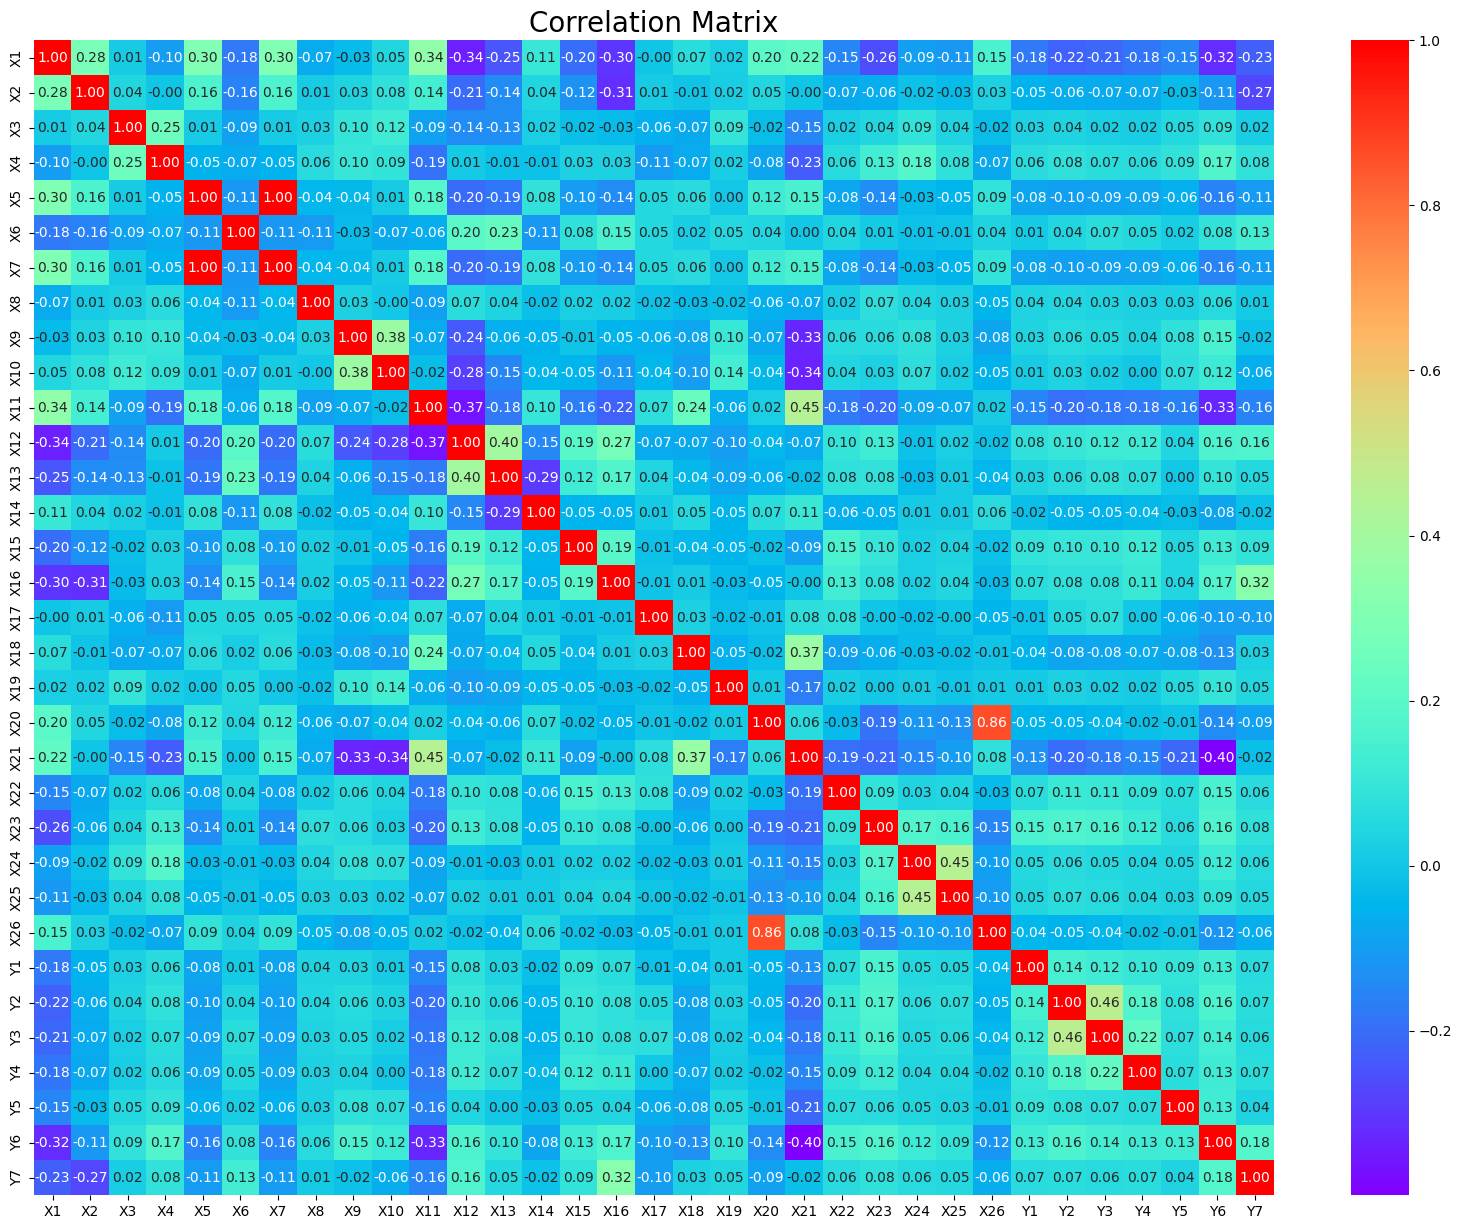

In [26]:
f, ax = plt.subplots(figsize= [20,15])
corr = data.corr()
sns.heatmap(data.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [27]:
data_feature = data.iloc[:, :26]
data_label = data.iloc[:, 26:]
data_label

,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,2,2,1,2,2,1,2
1,2,2,2,2,2,1,1
2,2,2,2,2,2,2,1
3,2,2,2,1,2,1,2
4,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
543770,2,2,2,2,2,2,2
543771,2,2,1,2,2,2,1
543772,2,2,2,2,2,2,1
543773,2,2,2,2,1,2,2


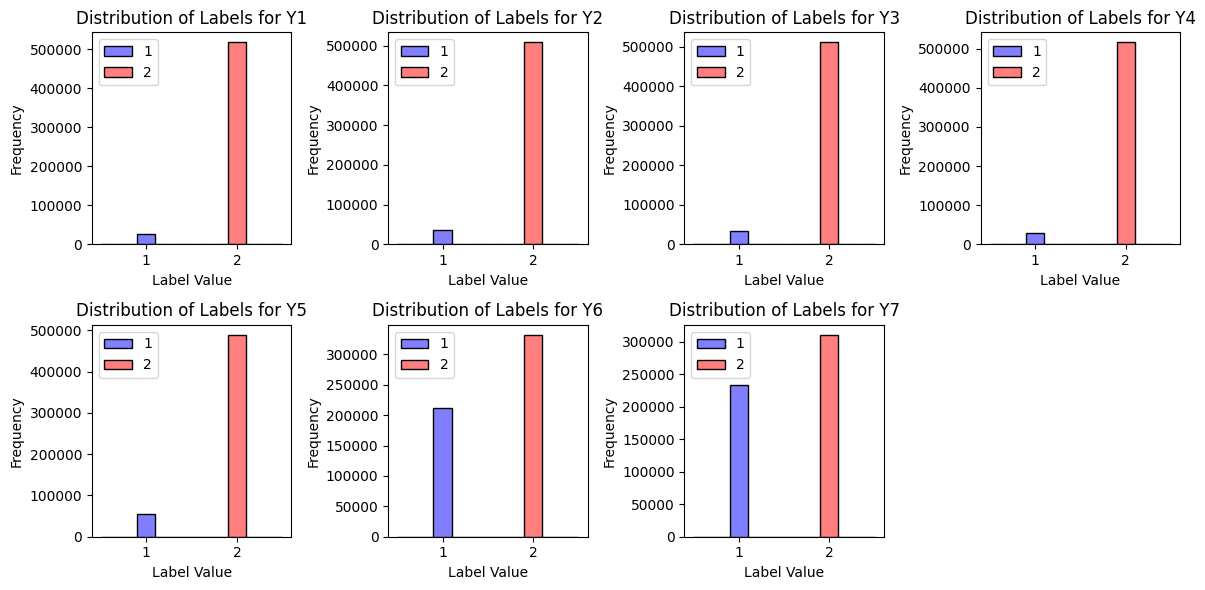

In [28]:
num_rows = 2  # Adjust as needed
num_cols = 4  # Adjust as needed

# Loop through each label column and create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
for i, label in enumerate(data_label.columns):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]

    # Filter values 1 and 2 from the label column
    values_1 = data_label[label][data_label[label] == 1]
    values_2 = data_label[label][data_label[label] == 2]

    # Create a histogram or bar plot on the current subplot
    sns.histplot(values_1, bins=5, color='blue', alpha=0.5, label='1', ax=ax)
    sns.histplot(values_2, bins=5, color='red', alpha=0.5, label='2', ax=ax)

    ax.set_title(f'Distribution of Labels for {label}')
    ax.set_xlabel('Label Value')
    ax.set_ylabel('Frequency')
    ax.legend()

if 7 < num_rows * num_cols:
    for j in range(7, num_rows * num_cols):
        fig.delaxes(axes.ravel()[j])

# Ensure tight layout to avoid overlapping
plt.tight_layout()
plt.show()

## Data Preprocessing

In [29]:
scaler = MinMaxScaler()
scaler.fit(data)

# Transform the DataFrame to obtain the normalized data
data_normalized = scaler.transform(data)

In [30]:
X = data_normalized[:, :26]
y = data_normalized[:, 26:]

In [31]:
data_normalize = pd.DataFrame(scaler.transform(data), columns=data.columns)
df_feature = data_normalize.iloc[:, :26]
df_label = data_normalize.iloc[:, 26:]

## Modelling

In [32]:
weight_list = []
for i, label in enumerate(df_label.columns):
    values_1 = df_label[label][df_label[label] == 1]
    values_2 = df_label[label][df_label[label] == 2]
    dist = 1 - (len(values_1) / len(df_label))
    weight_list.append(dist)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
weights_ = torch.Tensor(weight_list).to(device)
weights_

tensor([0.0483, 0.0652, 0.0605, 0.0508, 0.1008, 0.3895, 0.4290],
       device='cuda:0')

In [35]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [36]:

class WeightedDropout(tf.keras.layers.Layer):
    def __init__(self, rate=0.5):
        super(WeightedDropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            batch_size = tf.shape(inputs)[0]
            num_features = tf.shape(inputs)[-1]

            # Generate random weights
            weights = tf.random.normal(shape=(batch_size, num_features))

            # Create a binary mask for dropout
            mask = tf.random.uniform(shape=(batch_size, num_features)) > self.rate

            # Apply weighted dropout
            weighted_input = inputs * weights
            output = tf.where(mask, weighted_input, 0.0)

            return output

        return inputs

In [37]:
def ProposedModel(n_inputs, n_outputs):
    inputLayer = Input(shape=(n_inputs,))
    num_split = 10
    x = Dense(num_split, activation='softmax', kernel_initializer='he_uniform')(inputLayer)
    split = tf.split(x, num_or_size_splits=num_split, axis=-1)
    dropout_rate = 0.5
    dropout_output = [WeightedDropout(dropout_rate)(channel) for channel in split]
    concat = tf.concat(dropout_output, axis=-1)
    x = Dense(16, activation='relu')(concat)
    out = Dense(n_outputs, activation='sigmoid')(x)
    model = Model(inputs=inputLayer, outputs=out)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

In [38]:
class WeightedDropout(nn.Module):
    def __init__(self, p=0.5):
        super(WeightedDropout, self).__init__()
        self.p = p

    def forward(self, x):
        x = x.to(device)
        weights = nn.Parameter(torch.randn(x.shape)).to(device)
        mask = torch.rand(x.shape) > self.p
        mask = mask.to(device)
        weighted_input = x * weights
        output = weighted_input * mask
        return output

In [39]:
class ProposedModelPT(nn.Module):
    def __init__(self, in_dim=26, out_dim=7, p=0.5, split=10):
        super(ProposedModelPT, self).__init__()
        self.linear = nn.Linear(in_dim, split)
        self.conv1d = nn.Conv1d(in_channels=in_dim, out_channels=split, kernel_size=1)
        self.activation = nn.Softmax(dim=1)
        self.weighted_dropout = nn.ModuleList([WeightedDropout(p=p) for _ in range(split)])
        self.linear2 = nn.Linear(split, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, out_dim)
        
    def forward(self, x, **kwargs):
        x = self.activation(self.linear(x))
        x = [dropout(x[:, i]) for i, dropout in enumerate(self.weighted_dropout)]
        x = torch.stack(x, dim=1)
        x = self.activation2(self.linear2(x))
        x = F.softmax(self.linear3(x))

        return x

## Cross Validation

In [40]:
kfold = KFold(n_splits=10, shuffle=True)

In [41]:
fold_test = []
fold_pred = []
fold_prob = []

In [42]:
import warnings
warnings.filterwarnings("ignore")
for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    x_train, x_test, y_train, y_test = (X[train_idx]), (X[test_idx]), (y[train_idx]), (y[test_idx])
    # KERAS_PARAMS = dict(epochs=5, batch_size=32, verbose=0)
    # classifier = ClassifierChain(classifier=Keras(ProposedModel, False, KERAS_PARAMS))
    
    net = NeuralNetClassifier(
        ProposedModelPT,
        max_epochs=5,
        lr=0.01,
        batch_size=32,
        optimizer=optim.Adam,
        criterion=nn.BCELoss,
        criterion__weight=weights_,
        verbose=0,
        device=device
    )
    classifier = ClassifierChain(classifier=net)
    
    train_init = time.time()
    classifier.fit(x_train.astype(np.float32), y_train.astype(np.int64))
    train_time = time.time() - train_init
    
    test_init = time.time()
    prediction = classifier.predict_proba(x_test.astype(np.float32))
    test_time = time.time() - test_init

    fold_test.append(y_test)
    fold_prob.append(prediction)

    trues = torch.tensor(y_test)
    preds = torch.tensor(prediction.toarray())

    print(f"Fold: {fold+1} | Accuracy: {multilabel_accuracy(preds, trues, num_labels=7, average='micro').item():.5f} | Train Time: {train_time} | Test Time: {test_time}")  

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x832 and 26x10)

In [ ]:
model_name = 'ednn'
import pickle
with open(f'Results/{model_name}_fold_pred.pkl', 'wb') as file:
    pickle.dump(fold_pred, file)
# with open(f'Results/{model_name}_fold_test.pkl', 'wb') as file:
#     pickle.dump(fold_test, file)
with open(f'Results/{model_name}_fold_prob.pkl', 'wb') as file:
    pickle.dump(fold_prob, file)

In [ ]:
for i in range(10):
    trues = torch.tensor(fold_test[i])
    preds = torch.tensor(fold_pred[i])
    print(f'Fold: {i+1}')
    print(f"Accuracy (Micro)\t: {multilabel_accuracy(preds, trues, num_labels=7, average='micro').item():.5f}")
    print(f"Accuracy (Macro)\t: {multilabel_accuracy(preds, trues, num_labels=7, average='macro').item():.5f}")
    print(f"Precision (Micro)\t: {multilabel_precision(preds, trues, num_labels=7, average='micro').item():.5f}")
    print(f"Precision (Macro)\t: {multilabel_precision(preds, trues, num_labels=7, average='macro').item():.5f}")
    print(f"Recall (Micro)\t\t: {multilabel_recall(preds, trues, num_labels=7, average='micro').item():.5f}")
    print(f"Recall (Macro)\t\t: {multilabel_recall(preds, trues, num_labels=7, average='macro').item():.5f}")
    print(f"F1 Score (Micro)\t: {multilabel_f1_score(preds, trues, num_labels=7, average='micro').item():.5f}")
    print(f"F1 Score (Macro)\t: {multilabel_f1_score(preds, trues, num_labels=7, average='macro').item():.5f}")
    print(f"AUC ROC (Micro)\t\t: {multilabel_auroc(preds.float(), trues.long(), num_labels=7, average='micro').item():.5f}")
    print(f"AUC ROC (Macro)\t\t: {multilabel_auroc(preds.float(), trues.long(), num_labels=7, average='macro').item():.5f}")
    print('-'*20)

Fold: 1
Accuracy (Micro)	: 0.86861
Accuracy (Macro)	: 0.86861
Precision (Micro)	: 0.90109
Precision (Macro)	: 0.88306
Recall (Micro)		: 0.94691
Recall (Macro)		: 0.92449
F1 Score (Micro)	: 0.92343
F1 Score (Macro)	: 0.90279
AUC ROC (Micro)		: 0.70716
AUC ROC (Macro)		: 0.55611
--------------------
Fold: 2
Accuracy (Micro)	: 0.87286
Accuracy (Macro)	: 0.87286
Precision (Micro)	: 0.89740
Precision (Macro)	: 0.88094
Recall (Micro)		: 0.95778
Recall (Macro)		: 0.94004
F1 Score (Micro)	: 0.92661
F1 Score (Macro)	: 0.90940
AUC ROC (Micro)		: 0.69582
AUC ROC (Macro)		: 0.55621
--------------------
Fold: 3
Accuracy (Micro)	: 0.87143
Accuracy (Macro)	: 0.87143
Precision (Micro)	: 0.88989
Precision (Macro)	: 0.87531
Recall (Micro)		: 0.96596
Recall (Macro)		: 0.95227
F1 Score (Micro)	: 0.92637
F1 Score (Macro)	: 0.91144
AUC ROC (Micro)		: 0.67547
AUC ROC (Macro)		: 0.55418
--------------------
Fold: 4
Accuracy (Micro)	: 0.87096
Accuracy (Macro)	: 0.87096
Precision (Micro)	: 0.90102
Precision (Ma

In [ ]:
import numpy as np
import scipy.io as sci

def findmax(outputs):
    Max = -float("inf")
    index = 0
    for i in range(outputs.shape[0]):
        if outputs[i] > Max:
            Max = outputs[i]
            index = i
    return Max, index

def OneError(outputs, test_target):
    test_data_num = outputs.shape[0]
    class_num = outputs.shape[1]
    num = 0
    one_error = 0
    for i in range(test_data_num):
        if sum(test_target[i]) != class_num and sum(test_target[i]) != 0:
            Max, index = findmax(outputs[i])
            num = num + 1
            if test_target[i][index] != 1:
                one_error = one_error + 1
    return one_error / num

In [ ]:
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
    return temp/ y_true.shape[0]

def Precision(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

In [ ]:
for i in range(10):
    trues = torch.tensor(fold_test[i])
    preds = torch.tensor(fold_pred[i])
    print(f'Fold: {i+1}')
    print(f"Subset Accuracy\t\t: {multilabel_exact_match(preds, trues, num_labels=7).item():.5f}")
    print(f"Hamming Loss\t\t: {multilabel_hamming_distance(preds, trues, num_labels=7).item():.5f}")
    print(f"Accuracy Exp\t\t: {Accuracy(preds, trues):.5f}")
    print(f"Precision Exp\t\t: {Precision(preds, trues):.5f}")
    print(f"Recall Exp\t\t: {Recall(preds, trues):.5f}")
    print(f"F1-Score Exp\t\t: {multilabel_fbeta_score(preds, trues, beta=1.0, num_labels=7).item():.5f}")
    print(f"One Error\t\t: {OneError(fold_pred[i], fold_test[i]):.5f}")
    print(f"Coverage\t\t: {multilabel_coverage_error(preds.float(), trues, num_labels=7).item():.5f}")
    print(f"Ranking Loss\t\t: {multilabel_ranking_loss(preds.float(), trues, num_labels=7).item():.5f}")
    print(f"Average Precision\t: {multilabel_average_precision(preds.float(), trues.long(), num_labels=7).item():.5f}")
    print('-'*20)

Fold: 1
Subset Accuracy		: 0.40149
Hamming Loss		: 0.13139
Accuracy Exp		: 0.85595
Precision Exp		: 0.94592
Recall Exp		: 0.89790
F1-Score Exp		: 0.90279
One Error		: 0.07254
Coverage		: 6.58016
Ranking Loss		: 0.28839
Average Precision	: 0.87092
--------------------
Fold: 2
Subset Accuracy		: 0.41394
Hamming Loss		: 0.12714
Accuracy Exp		: 0.86153
Precision Exp		: 0.95682
Recall Exp		: 0.89500
F1-Score Exp		: 0.90940
One Error		: 0.06984
Coverage		: 6.60140
Ranking Loss		: 0.31065
Average Precision	: 0.87195
--------------------
Fold: 3
Subset Accuracy		: 0.40912
Hamming Loss		: 0.12857
Accuracy Exp		: 0.86084
Precision Exp		: 0.96473
Recall Exp		: 0.88733
F1-Score Exp		: 0.91144
One Error		: 0.07171
Coverage		: 6.63095
Ranking Loss		: 0.34403
Average Precision	: 0.86887
--------------------
Fold: 4
Subset Accuracy		: 0.40660
Hamming Loss		: 0.12904
Accuracy Exp		: 0.85847
Precision Exp		: 0.94945
Recall Exp		: 0.89834
F1-Score Exp		: 0.90527
One Error		: 0.07324
Coverage		: 6.57569
R